In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import collections

pd.options.mode.chained_assignment = None  # default='warn'
from statsmodels.stats import multitest
from scipy import stats

## Gene-level ReadZs from 10Xv3 sequencing correlations with MOp MERFISH

In [2]:
#Pull directly from gene_cell table because I want to collapse per mouse (2 mice total)
mop_df = pd.read_csv('../outputs/gene_cell/MOp_peripheral_ReadZs_gene_ontology.csv')

gb_cols = ['mouse','gene','ontology']

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/mouse with fewer than 20 cells
mop_df = mop_df[mop_df['num_gene_spots'].ge(5)]
mop_df = mop_df.groupby(gb_cols).filter(lambda g: len(g) >= 20)

#aggregate by mouse (over all slices)
#Calculate z from Lyapunov CLT for each gene in each sample
mop_agg_df = mop_df.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    num_slices = ('sample','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

mop_agg_df['z'] = mop_agg_df['score_sum']/np.sqrt(mop_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(mop_agg_df['z'])
mop_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    mop_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
mop_agg_df['bh_p'] = adj_p
mop_agg_df = mop_agg_df.rename(columns={'mouse':'merfish_mouse'})
mop_agg_df

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,1,Acta2,L2/3 IT,991,5,5.0,695.0,0.102431,91.602118,122.242160,8.285048,2.220446e-16,8.804734e-16
1,1,Acta2,L5 ET,106,3,5.0,888.5,0.095434,9.724163,13.084333,2.688292,7.181856e-03,1.179307e-02
2,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,9.342562,0.000000e+00,0.000000e+00
3,1,Acta2,L6 CT,265,3,5.0,516.0,0.176113,39.580953,33.029954,6.887035,5.696776e-12,1.891902e-11
4,1,Acta2,L6 IT,448,5,5.0,781.5,0.167048,69.549196,54.999854,9.378024,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2,Wnt7b,L5 ET,562,6,10.0,869.0,0.054671,25.664760,46.654497,3.757426,1.716700e-04,3.422509e-04
2510,2,Wnt7b,L5 IT,4906,6,18.0,636.0,0.052561,252.284730,275.239351,15.206725,0.000000e+00,0.000000e+00
2511,2,Wnt7b,L6 CT,1684,6,8.0,435.0,0.077132,111.832298,155.319639,8.973339,0.000000e+00,0.000000e+00
2512,2,Wnt7b,L6 IT,1053,6,8.0,661.0,0.083333,82.884489,97.084564,8.411979,0.000000e+00,0.000000e+00


In [4]:
#read in the 10X ReadZs gene-level dataset
rz_10x = pd.read_csv('../outputs/readzs/gene_level/MOp_10Xv3.csv')
rz_10x = rz_10x.rename(columns={'mouse':'readzs_mouse'})
rz_10x.head()

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,gene,rz_bh_corrected
0,chr4_Rspo1_plus,Vip___426003,603,6.0,-0.091192,1.0,1.0,NaN,0.354532,Vip,426003,chr4,+,Rspo1,1.0
1,chr4_Rspo1_plus,L6 CT___426003,35,5.0,-0.079529,1.0,1.0,NaN,0.354532,L6 CT,426003,chr4,+,Rspo1,1.0
2,chr4_Rspo1_plus,L5 IT___426003,26900,8.0,0.107795,1.0,1.0,NaN,0.354532,L5 IT,426003,chr4,+,Rspo1,1.0
3,chr4_Rspo1_plus,L2/3 IT___426003,718,7.0,0.263340,1.0,1.0,NaN,0.354532,L2/3 IT,426003,chr4,+,Rspo1,1.0
4,chr4_Col15a1_plus,L5 IT___426003,1606,6.0,-0.117295,1.0,1.0,NaN,0.227648,L5 IT,426003,chr4,+,Col15a1,1.0


In [34]:
rz_10x['gene'].eq('Flt1').any()

False

In [5]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(rz_10x, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,readzs_mouse,chr,strand,rz_bh_corrected
0,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,8.0,-0.020955,2.182229e-10,0.26,False,1.327871,457911,chr11,+,0.476667
1,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,7.0,-0.088194,9.360248e-02,1.00,NaN,0.376036,427378,chr11,+,1.000000
2,2,Adamts2,L2/3 IT,194,5,6.0,820.5,-0.185677,-30.205382,22.374981,...,8.0,-0.020955,2.182229e-10,0.26,False,1.327871,457911,chr11,+,0.476667
3,2,Adamts2,L2/3 IT,194,5,6.0,820.5,-0.185677,-30.205382,22.374981,...,7.0,-0.088194,9.360248e-02,1.00,NaN,0.376036,427378,chr11,+,1.000000
4,1,Adamts2,L6 IT,137,3,6.0,727.0,-0.178947,-22.776114,15.504994,...,8.0,-0.038736,2.182229e-10,0.26,False,1.327871,457911,chr11,+,0.476667


In [6]:
m[m['gene'].eq('Flt1')]

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,readzs_mouse,chr,strand,rz_bh_corrected


In [5]:
#calculate pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate ReadZs/SRRS gene/samples/mice with too few ontologies
gene_sample_ontology_df = (
    m.groupby([
        'gene',
        'merfish_mouse',
        'readzs_mouse'
    ]).filter(
        lambda g: g['ontology'].nunique() >= 2)
)

for (gene,merfish_mouse,readzs_mouse),g in gene_sample_ontology_df.groupby(['gene','merfish_mouse','readzs_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(merfish_mouse)
    corr_data['readzs_mouse'].append(readzs_mouse)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
226,Phactr2,1,427378,2,994.0,1.0,0.0,0.0,True
370,Unc5b,1,457911,2,3855.5,-1.0,0.0,0.0,True
229,Phactr2,2,457911,2,305.0,1.0,0.0,0.0,True
17,Barx2,2,457911,2,498.5,-1.0,0.0,0.0,True
16,Barx2,2,457909,2,498.5,-1.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...
170,Lama3,2,427378,2,733.5,1.0,1.0,1.0,False
171,Lsp1,1,426003,2,755.0,-1.0,1.0,1.0,False
327,Sox10,2,457911,2,4448.0,-1.0,1.0,1.0,False
153,Ikzf2,2,427378,2,39.0,-1.0,1.0,1.0,False


In [6]:
m['gene'].nunique()

90

In [7]:
corr_df['gene'].nunique()

76

In [8]:
radial_sig = [
    'Phactr2', 'Barx2', 'Unc5b', 'Egln3', 'Pdlim5', 'Prdm8', 'Nr4a2',
    'Tmem163', 'Myh14', 'C1ql3', 'Pou3f3', 'Ccdc3', 'Timp3', 'Pou3f1',
]

peripheral_sig = [
    'Phactr2', 'Unc5b', 'Barx2', 'Timp3', 'Prdm8', 'Hs3st5', 'Cbln2',
    'Ptpru', 'Fezf2', 'Itgb8', 'Ubash3b', 'Slc17a6', 'Rgs5', 'Prss23',
]

print(len(radial_sig),len(peripheral_sig))
print(set(radial_sig).intersection(peripheral_sig))

14 14
{'Phactr2', 'Unc5b', 'Barx2', 'Timp3', 'Prdm8'}


In [9]:
#multiple genes have significant ReadZs/SRRS Pearson correlations between pairs of spatial/10X samples
sig_genes = corr_df[corr_df['significant']]['gene'].unique()
display(sig_genes)

corr_df[corr_df['significant']].sort_values('gene')

array(['Phactr2', 'Unc5b', 'Barx2', 'Timp3', 'Prdm8', 'Hs3st5', 'Cbln2',
       'Ptpru', 'Fezf2', 'Itgb8', 'Ubash3b', 'Slc17a6', 'Rgs5', 'Prss23'],
      dtype=object)

,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
17,Barx2,2,457911,2,498.5,-1.000000,0.000000e+00,0.000000e+00,True
16,Barx2,2,457909,2,498.5,-1.000000,0.000000e+00,0.000000e+00,True
15,Barx2,1,457911,2,848.0,-1.000000,0.000000e+00,0.000000e+00,True
14,Barx2,1,457909,2,848.0,-1.000000,0.000000e+00,0.000000e+00,True
42,Cbln2,2,457909,7,1849.0,0.855046,9.727602e-05,2.496751e-03,True
43,Cbln2,2,457911,6,2165.0,0.978275,7.028394e-04,1.229969e-02,True
41,Cbln2,2,427378,8,1474.0,0.699067,2.583638e-03,3.430002e-02,True
117,Fezf2,1,426003,4,3756.0,-0.962672,1.264193e-04,2.863025e-03,True
144,Hs3st5,1,427378,4,445.0,0.906661,1.893295e-03,2.603280e-02,True
145,Hs3st5,2,427378,3,396.0,0.995888,2.532944e-05,6.965595e-04,True


In [42]:
corr_df.to_csv('peripheral_rzs_srrs_correlations.csv',index=False)

In [43]:
ind_cols = ['gene','merfish_mouse','readzs_mouse']
sig_inds = corr_df[corr_df['significant']].set_index(ind_cols).index
sig_gene_sample_ontology_df = gene_sample_ontology_df.set_index(ind_cols).loc[sig_inds].reset_index()
sig_gene_sample_ontology_df

,gene,merfish_mouse,readzs_mouse,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,...,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,chr,strand,rz_bh_corrected
0,Phactr2,1,427378,L2/3 IT,1671,6,6.0,691.0,-0.084287,-107.130652,...,1058,7.0,0.034894,0.0,0.0,True,1.176920,chr10,-,0.0
1,Phactr2,1,427378,L2/3 IT,1671,6,6.0,691.0,-0.084287,-107.130652,...,1058,7.0,0.034894,0.0,0.0,True,1.176920,chr10,-,0.0
2,Phactr2,1,427378,L5 IT,317,6,6.0,898.0,-0.049666,-11.126208,...,10352,7.0,0.150062,0.0,0.0,True,1.176920,chr10,-,0.0
3,Phactr2,1,427378,L5 IT,317,6,6.0,898.0,-0.049666,-11.126208,...,10352,7.0,0.150062,0.0,0.0,True,1.176920,chr10,-,0.0
4,Unc5b,1,457911,Oligo,7690,6,17.0,189.0,0.027735,185.434368,...,568,9.0,-0.309913,0.0,0.0,True,0.820505,chr10,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,Slc17a6,2,426003,L2/3 IT,1441,6,7.0,749.0,0.080292,83.539472,...,333,5.0,0.245621,0.0,0.0,True,0.161860,chr7,+,0.0
268,Slc17a6,2,426003,L5 IT,635,6,9.0,761.0,0.053973,33.429595,...,5127,6.0,0.231017,0.0,0.0,True,0.161860,chr7,+,0.0
269,Slc17a6,2,426003,L5 IT,635,6,9.0,761.0,0.053973,33.429595,...,5127,6.0,0.231017,0.0,0.0,True,0.161860,chr7,+,0.0
270,Slc17a6,2,426003,L5/6 NP,639,6,8.0,550.0,0.013514,10.667709,...,1747,7.0,0.083761,0.0,0.0,True,0.161860,chr7,+,0.0


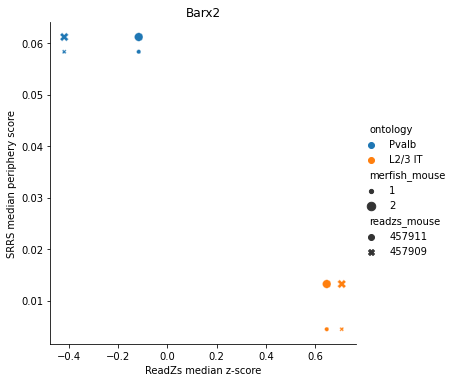

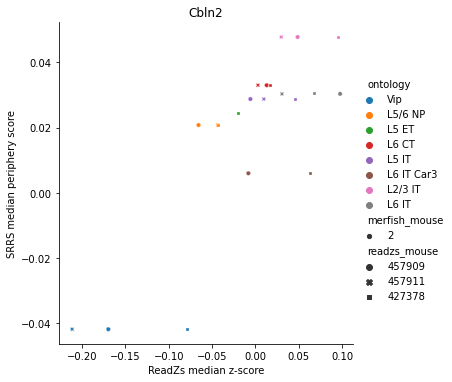

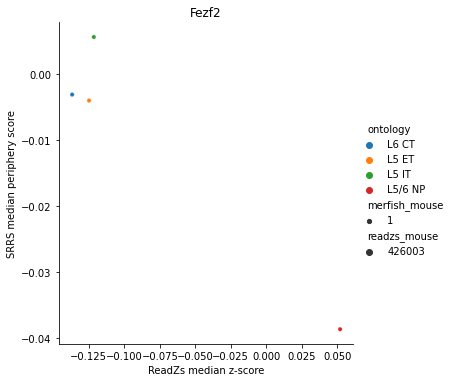

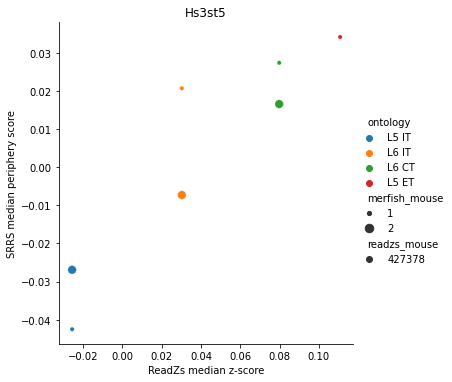

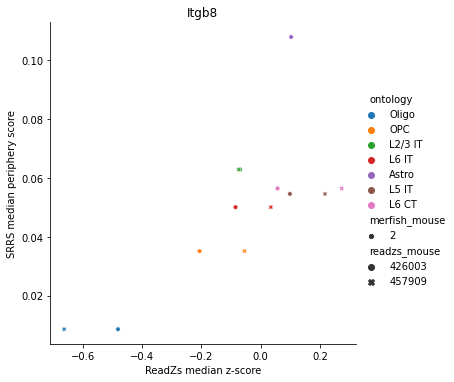

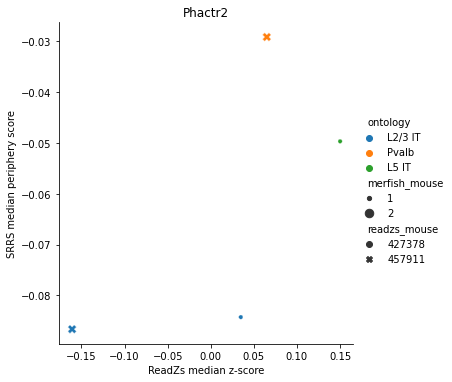

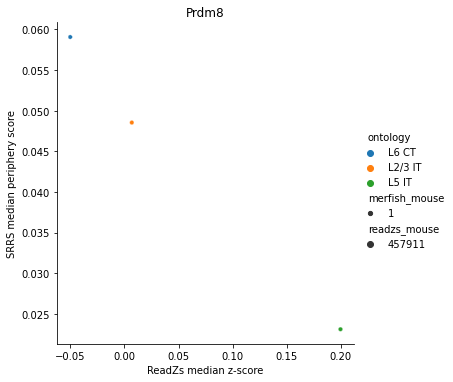

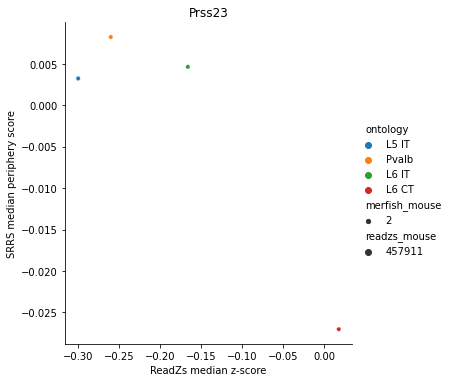

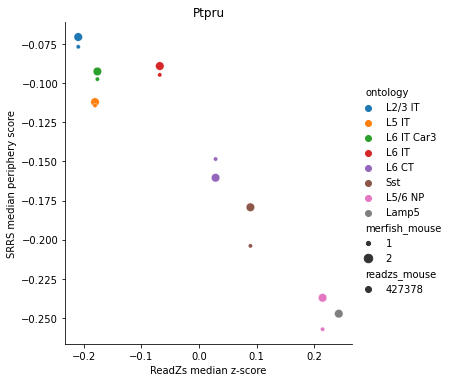

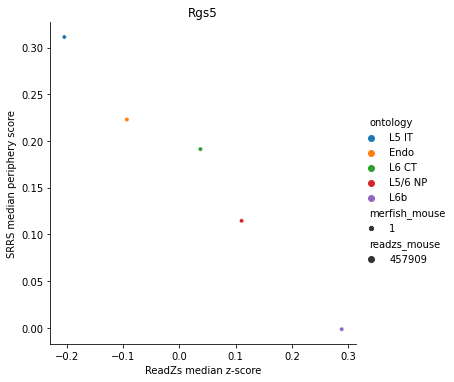

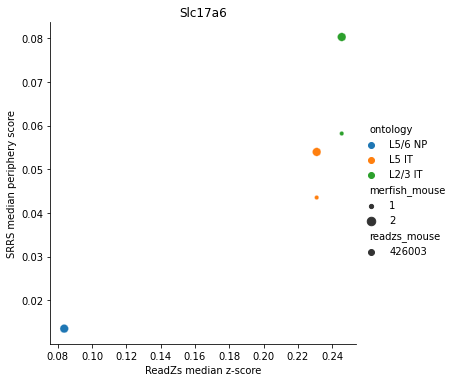

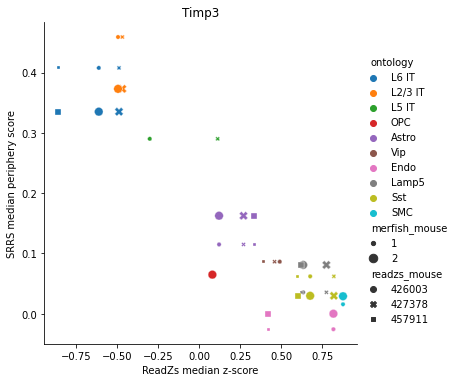

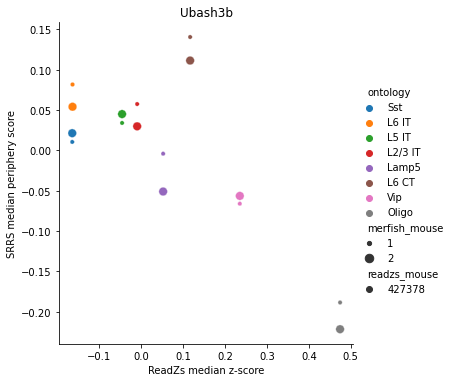

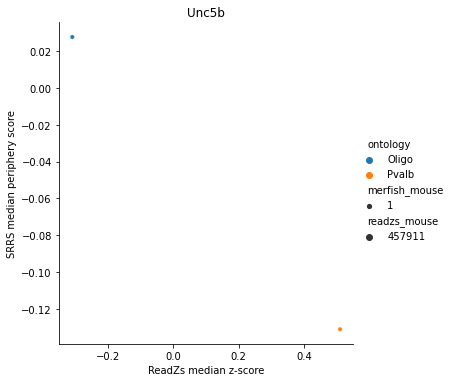

In [44]:
#all correlation data on single plot

#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_10X_readzs_correlations_by_mouse.pdf")

for gene,g in sig_gene_sample_ontology_df.groupby('gene'):
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{}'.format(gene))
    plt.show()
    #pdf.savefig(bbox_inches='tight')
    plt.close()

#pdf.close()

In [45]:
m.columns

Index(['merfish_mouse', 'gene', 'ontology', 'num_cells', 'num_slices',
       'med_gene_spots', 'med_spots', 'med_score', 'score_sum', 'var_sum', 'z',
       'p', 'bh_p', 'window', 'ontology_mouse',
       'sum_counts_per_window_per_ont', 'med_counts_per_window_per_ont',
       'median_z_scaled', 'chi2_p_val', 'perm_p_val', 'significant',
       'medians_range', 'readzs_mouse', 'chr', 'strand', 'rz_bh_corrected'],
      dtype='object')

In [13]:
m.groupby(['gene','ontology']).agg(
    mean_rzs = ('median_z_scaled','mean'),
).reset_index().to_csv('gene_ontology_rzs.csv',index=False)

In [46]:
plt.close()

In [47]:
#Plot all genes, not just the significant ones

pdf = matplotlib.backends.backend_pdf.PdfPages("all_peripheral_srrs_10X_readzs_correlations_by_mouse_gene.pdf")
sig_genes = corr_df[corr_df['significant']]['gene'].unique()

for gene,g in gene_sample_ontology_df.groupby('gene'):
    sig_title = 'significant in at least 1 MERFISH/10X sample pair' if gene in sig_genes else 'not significant'
    
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{} '.format(gene)+sig_title)
    #plt.show()
    pdf.savefig(bbox_inches='tight')
    plt.close()

pdf.close()

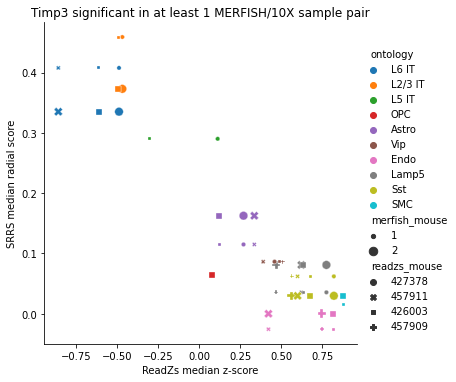

In [11]:
#Plot single gene

gene = 'Timp3'

sig_genes = corr_df[corr_df['significant']]['gene'].unique()

g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]

sig_title = 'significant in at least 1 MERFISH/10X sample pair' if gene in sig_genes else 'not significant'

g['readzs_mouse'] = g['readzs_mouse'].astype(str)
hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index

fig = sns.relplot(
    x = 'median_z_scaled',
    y = 'med_score',
    hue = 'ontology',
    size = 'merfish_mouse',
    style = 'readzs_mouse',
    hue_order = hue_order,
    data = g,
)
plt.xlabel('ReadZs median z-score')
plt.ylabel('SRRS median radial score')
plt.title('{} '.format(gene)+sig_title)
plt.show(fig)
fig.savefig('timp3_peripheral_readzs_corrs.svg')

plt.close()


## Window-level ReadZs from 10Xv3 sequencing correlations with MOp MERFISH

use the same SRRS_df from above, just correlate it to ReadZs windows instead of genes from the 10X data

In [3]:
#read in the 10X ReadZs window-level dataset
rz_10x = pd.read_csv('../outputs/readzs/window_level/MOp_10Xv3.csv')
rz_10x = rz_10x.rename(columns={'mouse':'readzs_mouse'})
rz_10x.head()

,window,ontology_mouse,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,ontology,readzs_mouse,chr,strand,bin_num,gene,rz_bh_corrected
0,chrX_32426_minus,Sst___427378,58,5.0,-0.446900,1.388166e-07,0.02,True,0.599749,Sst,427378,chrX,-,32426,Nhs,0.604545
1,chrX_32426_minus,Vip___427378,89,6.0,0.152849,1.388166e-07,0.02,True,0.599749,Vip,427378,chrX,-,32426,Nhs,0.604545
2,chrX_32397_plus,Vip___427378,61,6.0,-0.404210,5.492393e-02,1.00,NaN,0.561110,Vip,427378,chrX,+,32397,NaN,1.000000
3,chrX_32397_plus,Sst___427378,31,5.0,0.156900,5.492393e-02,1.00,NaN,0.561110,Sst,427378,chrX,+,32397,NaN,1.000000
4,chrX_32367_minus,L2/3 IT___427378,38,6.0,-0.235060,1.435780e-03,0.28,False,0.527298,L2/3 IT,427378,chrX,-,32367,Nhs,1.000000


In [4]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(rz_10x, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,readzs_mouse,chr,strand,bin_num,rz_bh_corrected
0,1,Adamts2,L2/3 IT,56,2,6.0,814.5,-0.271203,-10.749388,6.583127,...,-0.086682,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
1,2,Adamts2,L2/3 IT,194,5,6.0,820.5,-0.185677,-30.205382,22.374981,...,-0.086682,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
2,1,Adamts2,L6 IT,137,3,6.0,727.0,-0.178947,-22.776114,15.504994,...,0.147210,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
3,2,Adamts2,L6 IT,169,4,7.0,740.0,-0.178832,-29.516926,17.427624,...,0.147210,0.531317,1.0,NaN,0.233892,457911,chr11,+,10126,1.0
4,1,Adamts4,L6 CT,86,3,6.0,506.0,0.195745,11.706821,10.155526,...,0.155153,0.804498,1.0,NaN,0.257201,457909,chr1,+,34253,1.0


In [5]:
#There can be multiple ReadZs windows in the same gene
display(rz_10x.shape)
display(mop_agg_df.shape)
display(m.shape)

(16049, 16)

(2514, 13)

(22693, 27)

In [6]:
#For each ReadZs window/merf-mouse/10x-mouse, I'll test whether the peripheral score of that gene 
#is correlated with the ReadZs score with pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate ReadZs windows with too few ontologies
gene_sample_ontology_df = (
    m.groupby([
        'window',
        'merfish_mouse',
        'readzs_mouse'
    ]).filter(
        lambda g: g['ontology'].nunique() >= 5)
)

for (window,merfish_mouse,readzs_mouse),g in gene_sample_ontology_df.groupby(['window','merfish_mouse','readzs_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    gene = g['gene'].unique()[0] #all will have the same gene
    
    corr_data['window'].append(window)
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(merfish_mouse)
    corr_data['readzs_mouse'].append(readzs_mouse)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,window,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
986,chr7_22809_plus,Spon1,1,457909,6,2001.0,-0.986710,3.193009e-09,0.000003,True
989,chr7_22809_plus,Spon1,2,427378,7,1517.0,-0.903706,9.326737e-06,0.003532,True
509,chr18_17344_plus,Cbln2,2,457911,6,2165.0,0.932436,9.892198e-06,0.003532,True
990,chr7_22809_plus,Spon1,2,457909,6,1558.0,-0.896414,7.875413e-05,0.018247,True
508,chr18_17344_plus,Cbln2,2,457909,7,1849.0,0.858397,8.518500e-05,0.018247,True
...,...,...,...,...,...,...,...,...,...,...
1021,chr8_5842_minus,Unc5d,1,427378,5,1786.0,0.006458,9.917772e-01,0.995207,False
890,chr6_5462_minus,Grm8,1,426003,5,5317.0,-0.005954,9.924190e-01,0.995207,False
817,chr4_5775_plus,Epha7,2,457911,6,3764.0,-0.003932,9.941014e-01,0.995584,False
872,chr6_10861_plus,Chn2,2,427378,6,120.5,0.003564,9.946545e-01,0.995584,False


In [7]:
#there are only 7 window/Merfish-mouse/ReadZs-mouse groups with significant correlation after BH
#only four genes Spon1/Cbln2/Grm1/Cdh12
#
#from gene-level the genes were
#array(['Timp3', 'Cbln2', 'Ptpru', 'Itgb8', 'Ubash3b', 'Rgs5', 'Cobll1',
#       'Ntng2'], dtype=object)
#
# only Cbln2 is found to be significantly correlated between SRRS/ReadZs in both
#

corr_df[corr_df['significant']]

,window,gene,merfish_mouse,readzs_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
986,chr7_22809_plus,Spon1,1,457909,6,2001.0,-0.986710,3.193009e-09,0.000003,True
989,chr7_22809_plus,Spon1,2,427378,7,1517.0,-0.903706,9.326737e-06,0.003532,True
509,chr18_17344_plus,Cbln2,2,457911,6,2165.0,0.932436,9.892198e-06,0.003532,True
990,chr7_22809_plus,Spon1,2,457909,6,1558.0,-0.896414,7.875413e-05,0.018247,True
508,chr18_17344_plus,Cbln2,2,457909,7,1849.0,0.858397,8.518500e-05,0.018247,True
10,chr10_2138_minus,Grm1,1,457909,7,1279.0,-0.833519,2.125643e-04,0.037943,True
370,chr15_4174_plus,Cdh12,1,457911,7,2913.0,0.970468,2.833130e-04,0.043347,True


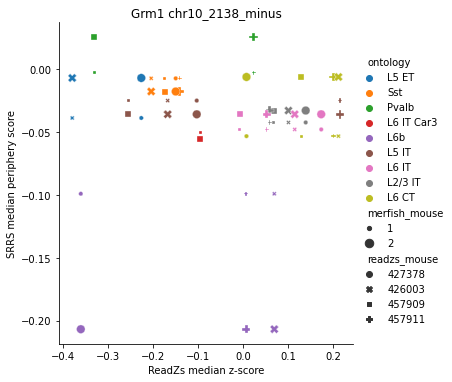

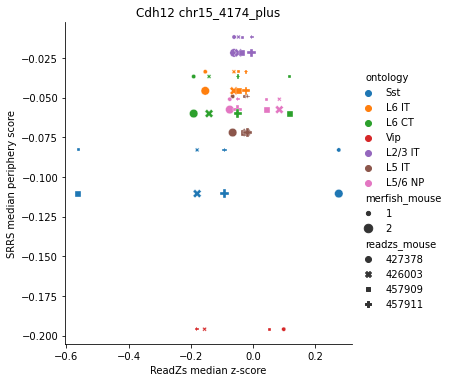

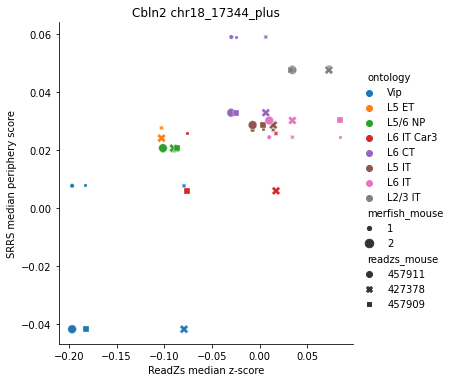

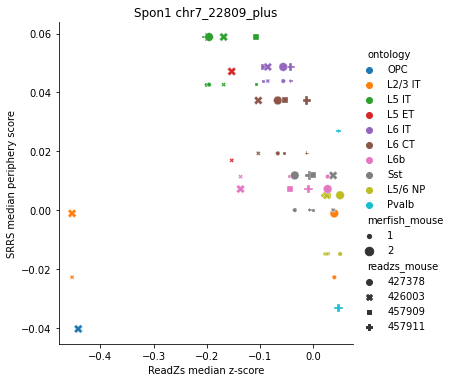

In [8]:
sig_windows = corr_df[corr_df['significant']]['window'].unique()

sig_gene_sample_ontology_df = gene_sample_ontology_df[
    gene_sample_ontology_df['window'].isin(sig_windows)
]

#all correlation data on single plot
#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_10X_readzs_correlations_by_mouse_windows.pdf")

for window,g in sig_gene_sample_ontology_df.groupby('window'):
    gene = g['gene'].unique()[0] #all will have the same gene
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{} {}'.format(gene,window))
    plt.show()
    #pdf.savefig(bbox_inches='tight')
    plt.close()

#pdf.close()

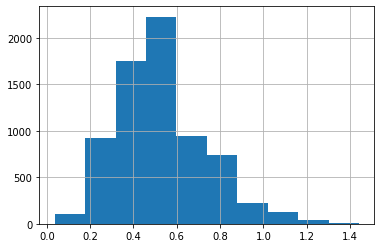

In [10]:
gene_sample_ontology_df['window_readzs_span'] = (
    gene_sample_ontology_df
        .groupby('window')['median_z_scaled']
        .transform(lambda v: v.max()-v.min())
)

gene_sample_ontology_df['window_readzs_span'].hist()
plt.show()
plt.close()

In [11]:
#Plot all windows, not just the significant ones

sig_windows = corr_df[corr_df['significant']]['window'].unique()

#all correlation data on single plot
pdf = matplotlib.backends.backend_pdf.PdfPages("all_peripheral_srrs_10X_readzs_correlations_by_mouse_windows.pdf")

for window,g in gene_sample_ontology_df[gene_sample_ontology_df['window_readzs_span'].ge(0.6)].groupby('window'):
    sig_str = 'significant in at least one sample pair' if window in sig_windows else 'not significant'
    
    gene = g['gene'].unique()[0] #all will have the same gene
    g['readzs_mouse'] = g['readzs_mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'readzs_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{} ({}) {}'.format(gene,window,sig_str))
    #plt.show()
    pdf.savefig(bbox_inches='tight')
    plt.close()

pdf.close()

# Gene-level ReadZs SS2 correlations with SRRS MOp

Can use the same SRRS table generated above for the 10X ReadZs comparisons since the cell-types are the same

In [10]:
rz_ss2 = pd.read_csv('../outputs/readzs/gene_level/MOp_SS2.csv')
rz_ss2.head()

,gene,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,Pxdc1,chr13_Pxdc1,Sncg,523,12.0,-0.188515,0.0,0.0,True,1.986624,0.0
1,Pxdc1,chr13_Pxdc1,Pvalb,1678,12.0,-0.096740,0.0,0.0,True,1.986624,0.0
2,Pxdc1,chr13_Pxdc1,Vip,16511,31.0,-0.094528,0.0,0.0,True,1.986624,0.0
3,Pxdc1,chr13_Pxdc1,Sst,17065,23.0,-0.093417,0.0,0.0,True,1.986624,0.0
4,Pxdc1,chr13_Pxdc1,L5 IT,3232,12.0,-0.076602,0.0,0.0,True,1.986624,0.0


In [11]:
rz_ss2['gene'].eq('Flt1').any()

True

In [12]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(rz_ss2, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,bh_p,window,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
0,1,Acta2,L2/3 IT,991,5,5.0,695.0,0.102431,91.602118,122.242160,...,8.804734e-16,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
1,2,Acta2,L2/3 IT,24,1,5.0,934.0,0.030987,2.560018,3.137224,...,1.939587e-01,chr19_Acta2,156,2.0,-0.245706,0.0,0.0,True,1.211264,0.0
2,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,...,0.000000e+00,chr19_Acta2,761,5.0,0.146247,0.0,0.0,True,1.211264,0.0
3,1,Acta2,L6 CT,265,3,5.0,516.0,0.176113,39.580953,33.029954,...,1.891902e-11,chr19_Acta2,464,1.0,0.262013,0.0,0.0,True,1.211264,0.0
4,1,Acta2,L6 IT,448,5,5.0,781.5,0.167048,69.549196,54.999854,...,0.000000e+00,chr19_Acta2,68,2.0,-0.399946,0.0,0.0,True,1.211264,0.0


In [13]:
#calculate pearson correlations and BH corrected p-values
corr_data = {
    'gene':[],
    'merfish_mouse':[],
    'num_celltypes':[],
    'med_SRRS_cells_per_celltype':[],
    'pearson_r':[],
    'pearson_p':[],
}

#can't correlate ReadZs/SRRS gene/samples with only a single ontology
gene_sample_ontology_df = m.groupby(['gene','merfish_mouse']).filter(lambda g: g['ontology'].nunique() >= 2)

for (gene,sample_name),g in gene_sample_ontology_df.groupby(['gene','merfish_mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_z_scaled'])
    
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(sample_name)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p')
_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

,gene,merfish_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
129,Grm8,1,10,1892.0,-0.933785,0.000078,0.026462,True
183,Nr4a1,1,10,1900.0,0.889678,0.000566,0.096529,False
176,Nos1,2,6,392.0,0.965650,0.001750,0.154258,False
199,Parm1,2,10,1095.5,0.844607,0.002105,0.154258,False
49,Cd24a,2,5,191.0,0.980638,0.003225,0.154258,False
...,...,...,...,...,...,...,...,...
117,Fst,2,2,985.5,1.000000,1.000000,1.000000,False
116,Fst,1,2,1163.0,-1.000000,1.000000,1.000000,False
111,Flt1,2,2,1222.5,1.000000,1.000000,1.000000,False
234,Ptger3,2,2,26.5,-1.000000,1.000000,1.000000,False


In [14]:
#only Grm8 is significant
corr_df[corr_df['significant']]

,gene,merfish_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
129,Grm8,1,10,1892.0,-0.933785,0.000078,0.026462,True


In [27]:
sig_genes = corr_df[corr_df['significant']]['gene'].unique()

sig_gene_sample_ontology_df = gene_sample_ontology_df[
    gene_sample_ontology_df['gene'].isin(sig_genes)
]

#all correlation data on single plot
#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_SS2_readzs_correlations_by_mouse_genes.pdf")

for gene,g in sig_gene_sample_ontology_df.groupby('gene'):
    hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_z_scaled',
        y = 'med_score',
        hue = 'ontology',
        style = 'merfish_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('ReadZs median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{}'.format(gene))
    plt.show()
    #pdf.savefig(bbox_inches='tight')
    plt.close()

#pdf.close()

In [28]:
#Flt1 not found in 10X data
#Previously it WAS found
#DIFFERENCE WAS THAT Flt1 is a minus-strand gene, but the significant bin was the plus strand
rz_10x['gene'].eq('Flt1').any()

False

In [15]:
#Flt1 found in SS2 (unstranded) but not significant
rz_ss2[rz_ss2['gene'].eq('Flt1')]

,gene,window,ontology,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
336,Flt1,chr5_Flt1,Lamp5,71,2.0,-0.599768,1.324658e-09,0.34,False,1.056614,0.408687
337,Flt1,chr5_Flt1,Endo,14835,862.0,0.026730,1.324658e-09,0.34,False,1.056614,0.408687
338,Flt1,chr5_Flt1,L6b,679,2.0,0.060212,1.324658e-09,0.34,False,1.056614,0.408687
339,Flt1,chr5_Flt1,L5 IT,329,1.0,0.167881,1.324658e-09,0.34,False,1.056614,0.408687
340,Flt1,chr5_Flt1,L6 IT,162,1.0,0.176370,1.324658e-09,0.34,False,1.056614,0.408687
341,Flt1,chr5_Flt1,Sst,128,2.0,0.176800,1.324658e-09,0.34,False,1.056614,0.408687
342,Flt1,chr5_Flt1,L6 CT,416,1.0,0.181648,1.324658e-09,0.34,False,1.056614,0.408687
343,Flt1,chr5_Flt1,L5/6 NP,35,1.0,0.183569,1.324658e-09,0.34,False,1.056614,0.408687
344,Flt1,chr5_Flt1,Pvalb,32,1.0,0.183784,1.324658e-09,0.34,False,1.056614,0.408687
345,Flt1,chr5_Flt1,L2/3 IT,64,1.0,0.185289,1.324658e-09,0.34,False,1.056614,0.408687


In [18]:
gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,...,bh_p,window,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,median_z_scaled,chi2_p_val,perm_p_val,significant,medians_range,rz_bh_corrected
633,1,Flt1,Endo,2140,6,29.0,155.0,-0.042081,-94.173397,64.046880,...,2.671619e-31,chr5_Flt1,14835,862.0,0.026730,1.324658e-09,0.34,False,1.056614,0.408687
634,2,Flt1,Endo,1517,6,29.0,153.0,-0.036585,-65.791544,45.068126,...,4.853192e-22,chr5_Flt1,14835,862.0,0.026730,1.324658e-09,0.34,False,1.056614,0.408687
635,1,Flt1,L2/3 IT,22,1,6.0,628.0,0.694375,12.699482,2.554645,...,7.741111e-15,chr5_Flt1,64,1.0,0.185289,1.324658e-09,0.34,False,1.056614,0.408687
636,1,Flt1,L5 IT,45,2,7.0,708.0,0.609618,22.350518,4.558263,...,0.000000e+00,chr5_Flt1,329,1.0,0.167881,1.324658e-09,0.34,False,1.056614,0.408687
637,1,Flt1,SMC,1317,6,15.0,329.0,-0.014587,9.717386,82.417629,...,3.467988e-01,chr5_Flt1,1036,32.0,0.456846,1.324658e-09,0.34,False,1.056614,0.408687
638,2,Flt1,SMC,928,6,14.0,329.5,-0.008775,15.245041,59.190262,...,6.812515e-02,chr5_Flt1,1036,32.0,0.456846,1.324658e-09,0.34,False,1.056614,0.408687


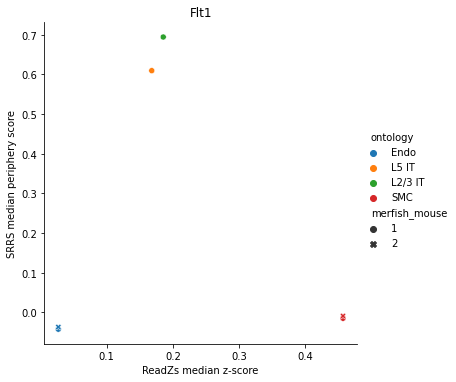

In [20]:
#Hand-plotting genes of interest for ss2

#all correlation data on single plot
#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_SS2_readzs_correlations_by_mouse_genes.pdf")
gene = 'Flt1'
g = gene_sample_ontology_df[gene_sample_ontology_df['gene'].eq(gene)]
hue_order = g.groupby('ontology')['median_z_scaled'].mean().sort_values().index

sns.relplot(
    x = 'median_z_scaled',
    y = 'med_score',
    hue = 'ontology',
    style = 'merfish_mouse',
    hue_order = hue_order,
    data = g,
)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('ReadZs median z-score')
plt.ylabel('SRRS median periphery score')
plt.title('{}'.format(gene))
plt.show()
#pdf.savefig(bbox_inches='tight')
plt.close()

In [30]:
#seeing if Timp3 was nearly significant in SS2 ReadZs correlations (yes before BH)
corr_df[corr_df['gene'].eq('Timp3')]

,gene,merfish_mouse,num_celltypes,med_SRRS_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
308,Timp3,1,10,232.5,-0.723519,0.018021,0.349427,False
309,Timp3,2,8,670.5,-0.716322,0.045618,0.454956,False


In [27]:
tenX_ann = pd.read_csv('/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X.cell.cluster.annotation.csv')
tenX_ann = tenX_ann[tenX_ann['subclass_label'].eq('Oligo')]

tenX_mem = pd.read_csv('/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X.cell.cluster.membership.csv')
tenX_ann.merge(tenX_mem,left_on='cluster_id',right_on='x')

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,Unnamed: 0,x
0,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,TGTACAGTCAGCTGTA-1L8TX_181211_01_G12,71
1,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,TGTGGCGCATCCGCGA-1L8TX_181211_01_G12,71
2,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,GGGTGAATCTGAACGT-2L8TX_181211_01_H12,71
3,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,TTTCAGTTCTCAACCC-2L8TX_181211_01_H12,71
4,71,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38,ATGGATCAGCGAGGAG-3L8TX_181211_01_A01,71
...,...,...,...,...,...,...,...,...
532,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TACGGGCTCTGTGCTC-12L8TX_190430_01_G08,74
533,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TACGTCCGTGTCACAT-12L8TX_190430_01_G08,74
534,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TCAAGTGCATCCTGTC-12L8TX_190430_01_G08,74
535,74,Oligo Opalin_2,Oligo,Non-Neuronal,#478662,92,TTCCACGAGATGCGAC-12L8TX_190430_01_G08,74


In [30]:
tenX_ann = pd.read_csv('/oak/stanford/groups/horence/rob/readzs_fork/MOp_10Xv3_metadata.tsv',sep='\t')
tenX_ann[tenX_ann['subclass_label'].eq('Oligo')]

,cell_id,cluster_id,library,cell_bc,cluster_label,subclass_label,class_label,cluster_color,size
39239,L8TX_181211_01_G12_AAACGCTGTATCGAGG,73,L8TX_181211_01_G12,AAACGCTGTATCGAGG,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39240,L8TX_181211_01_G12_AACCATGAGGTGCATG,73,L8TX_181211_01_G12,AACCATGAGGTGCATG,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39241,L8TX_181211_01_G12_ACAGGGACACGGGTAA,73,L8TX_181211_01_G12,ACAGGGACACGGGTAA,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39242,L8TX_181211_01_G12_AGAGCCCAGCCTCTGG,73,L8TX_181211_01_G12,AGAGCCCAGCCTCTGG,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
39243,L8TX_181211_01_G12_AGGAATAGTGATGGCA,73,L8TX_181211_01_G12,AGGAATAGTGATGGCA,Oligo Opalin_1,Oligo,Non-Neuronal,#474662,375
...,...,...,...,...,...,...,...,...,...
70667,L8TX_190430_01_G08_GTGTTCCTCCACAAGT,71,L8TX_190430_01_G08,GTGTTCCTCCACAAGT,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38
70668,L8TX_190430_01_G08_GTTGTAGGTCCATAGT,71,L8TX_190430_01_G08,GTTGTAGGTCCATAGT,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38
70669,L8TX_190430_01_G08_TAACGACTCGGAAGGT,71,L8TX_190430_01_G08,TAACGACTCGGAAGGT,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38
70670,L8TX_190430_01_G08_TGAGCGCGTGCTGCAC,71,L8TX_190430_01_G08,TGAGCGCGTGCTGCAC,Oligo Enpp6_1,Oligo,Non-Neuronal,#6B998D,38


In [31]:
ss2_ann = pd.read_csv('/oak/stanford/groups/horence/rob/readzs_fork/MOp_SS2_metadata.tsv',sep='\t')
ss2_ann[tenX_ann['subclass_label'].eq('Oligo')]

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,cell_id,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size
